## Import Packages

In [1]:
#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import random
import tensorflow as tf
import keras
from keras.models import Sequential ,Model
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Lambda
from keras.models import load_model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


Using TensorFlow backend.


## Parameters

In [2]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
WANTED_LABELS = ['traffic light']
WANTED_IDXS=[]
for i in range (len(WANTED_LABELS)):
    WANTED_IDXS.append(LABELS.index(WANTED_LABELS[i]))


IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')

#ANCHORS = [18.3274,21.6763,  59.9827,66.001,  106.83,175.179,  252.25,112.889,  312.657,293.385]
#ANCHORS=np.array(ANCHORS)/25
ANCHORS = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
ANCHORS=np.array(ANCHORS)*1.3
OBJ_THRESHOLD    = 0.18
NMS_THRESHOLD    = 0

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

## helper functions

In [3]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [4]:
class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

In [5]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))
    
def softmax(x):
    return(np.exp(x)/(np.exp(x)).sum(-1, keepdims=True))

def iou(b1,b2):
    x1_min=b1.x-b1.w/2
    x1_max=b1.x+b1.w/2
    y1_min=b1.y-b1.h/2
    y1_max=b1.y+b1.h/2
    x2_min=b2.x-b2.w/2
    x2_max=b2.x+b2.w/2
    y2_min=b2.y-b2.h/2
    y2_max=b2.y+b2.h/2
    x_intersect=0
    y_intersect=0
    if((x1_min>x2_min)&(x1_min<x2_max)):
        x_intersect=x2_max-x1_min-max(0,x2_max-x1_max)
    elif((x2_min>x1_min)&(x2_min<x1_max)):
        x_intersect=x1_max-x2_min-max(0,x1_max-x2_max)
    if((y1_min>y2_min)&(y1_min<y2_max)):
        y_intersect=y2_max-y1_min-max(0,y2_max-y1_max)
    elif((y2_min>y1_min)&(y2_min<y1_max)):
        y_intersect=y1_max-y2_min-max(0,y1_max-y2_max)
    intersect=x_intersect*y_intersect
    return intersect/(b1.w*b1.h+b2.w*b2.h-intersect)

In [6]:
class bbox:
    def __init__(self,x,y,w,h,c,classes):
        self.x=x
        self.y=y
        self.w=w
        self.h=h
        self.c=c
        self.classes=classes
        self.label=-1
        self.score=-1
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

In [7]:
def get_YOLO_boxes(YOLO_out,con_thre,NMS_thre,anchors):
    a=YOLO_out[0]
    Cells_x=a.shape[0]
    Cells_y=a.shape[1]
    BOXES=a.shape[2]
    CLASS=a[..., 5:].shape[3]
    a[...,4]=sigmoid(a[...,4])
    #print(a[...,4]>con_thre)
    a[...,5:]=np.expand_dims(a[...,4],-1)*softmax(a[...,5:])
    a[...,5:][a[...,5:]<con_thre]=0
    bboxes=[]
    for r in range(Cells_x):
        for c in range(Cells_y):
            for BOX in range(BOXES):
                classes=a[r,c,BOX,5:]
                confidence=a[r,c,BOX,4]
                #print(confidence)
                if ((classes.sum()!=0)&(confidence> con_thre)):
                    #print('hi')
                    x=(c+sigmoid(a[r,c,BOX,0]))/Cells_x
                    y=(r+sigmoid(a[r,c,BOX,1]))/Cells_y
                    w=(anchors[2*BOX]*np.exp(a[r,c,BOX,2]))/Cells_x
                    h=(anchors[2*BOX+1]*np.exp(a[r,c,BOX,3]))/Cells_y
                    bboxes.append(bbox(x,y,w,h,confidence,classes))

    return bboxes


    #NMS                
def NMS(bboxes,YOLO_out,con_thre,NMS_thre,anchors):
    a=YOLO_out[0]
    Cells_x=a.shape[0]
    Cells_y=a.shape[1]
    BOXES=a.shape[2]
    CLASS=a[..., 5:].shape[3]
    for c in WANTED_IDXS:
        sorted_class_indices = list(reversed(np.argsort([bbox.classes[c] for bbox in bboxes])))
        for i in range(len(sorted_class_indices)):
            if bboxes[sorted_class_indices[i]].classes[c]==0:
                continue
            for j in range (i+1,len(sorted_class_indices)):
                if bboxes[sorted_class_indices[j]].classes[c]==0:
                    continue
                if iou(bboxes[sorted_class_indices[i]],bboxes[sorted_class_indices[j]])>NMS_thre:
                    bboxes[sorted_class_indices[j]].classes[c]=0

    bboxes = [box for box in bboxes if ((box.get_score() > con_thre)&(box.get_label() in WANTED_IDXS))]
    
    return bboxes
    
def draw_bboxes(image,bboxes,labels,wanted_labels):
    if bboxes==[]:
        return None
    
    bboxes=sorted(bboxes, key=lambda bbox: bbox.get_score())    
    box=bboxes[-1]
    xmin=int((box.x-box.w/2)*image.shape[1])
    xmax=int((box.x+box.w/2)*image.shape[1])
    ymin=int((box.y-box.h/2)*image.shape[0])
    ymax=int((box.y+box.h/2)*image.shape[0])
    
    xmin=max(0,xmin)
    xmin=min(image.shape[1]-1,xmin)
    
    xmax=max(0,xmax)
    xmax=min(image.shape[1]-1,xmax)
    
    ymin=max(0,ymin)
    ymin=min(image.shape[0]-1,ymin)
    
    ymax=max(0,ymax)
    ymax=min(image.shape[0]-1,ymax)
    
    to_classify_image=image[ymin:ymax,xmin:xmax,:]
    return to_classify_image

## preparing model

@article{redmon2016yolo9000,
  title={YOLO9000: Better, Faster, Stronger},
  author={Redmon, Joseph and Farhadi, Ali},
  journal={arXiv preprint arXiv:1612.08242},
  year={2016}
}

In [8]:
input_layer=Input(shape=(416,416,3))

x=Conv2D(16,(3,3),strides=(1, 1),padding='same',name='conv_1', use_bias=False)(input_layer)
x=BatchNormalization(name='norm_1',axis=-1)(x)
x=LeakyReLU(alpha=0)(x)
x=MaxPooling2D(pool_size=(2, 2))(x)

x=Conv2D(32,(3,3),strides=(1, 1),padding='same',name='conv_2', use_bias=False)(x)
x=BatchNormalization(name='norm_2',axis=-1)(x)
x=LeakyReLU(alpha=0)(x)
x=MaxPooling2D(pool_size=(2, 2))(x)

x=Conv2D(64,(3,3),strides=(1, 1),padding='same',name='conv_3', use_bias=False)(x)
x=BatchNormalization(name='norm_3',axis=-1)(x)
x=LeakyReLU(alpha=0.1)(x)
x=MaxPooling2D(pool_size=(2, 2))(x)

x=Conv2D(128,(3,3),strides=(1, 1),padding='same',name='conv_4', use_bias=False)(x)
x=BatchNormalization(name='norm_4',axis=-1)(x)
x=LeakyReLU(alpha=0.1)(x)
x=MaxPooling2D(pool_size=(2, 2))(x)

x=Conv2D(256,(3,3),strides=(1, 1),padding='same',name='conv_5', use_bias=False)(x)
x=BatchNormalization(name='norm_5',axis=-1)(x)
x=LeakyReLU(alpha=0.1)(x)
x=MaxPooling2D(pool_size=(2, 2))(x)

x=Conv2D(512,(3,3),strides=(1, 1),padding='same',name='conv_6', use_bias=False)(x)
x=BatchNormalization(name='norm_6',axis=-1)(x)
x=LeakyReLU(alpha=0.1)(x)
x=MaxPooling2D(pool_size=(2, 2),strides=(1,1),padding='same')(x)

x=Conv2D(1024,(3,3),strides=(1, 1),padding='same',name='conv_7', use_bias=False)(x)
x=BatchNormalization(name='norm_7',axis=-1)(x)
x=LeakyReLU(alpha=0.1)(x)

x=Conv2D(512,(3,3),strides=(1, 1),padding='same',name='conv_8', use_bias=False)(x)
x=BatchNormalization(name='norm_8',axis=-1)(x)
x=LeakyReLU(alpha=0.1)(x)

x=Conv2D(BOX*(CLASS+5),(1,1),strides=(1, 1),padding='same',name='conv_9')(x)

output=Reshape((GRID_H,GRID_W,BOX,5+CLASS))(x)

model=Model([input_layer],output)


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 416, 416, 16)      432       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 208, 208, 32)      4608      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 208, 208, 32)      128       
__________

In [10]:
weight_reader = WeightReader('YOLO/yolov2-tiny.weights')

In [11]:
weight_reader.reset()
nb_conv = 9

weight_reader.read_bytes(1)

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    print("-------------------------")
    print("layer:",i)
    

    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)
        weights = norm_layer.set_weights([gamma, beta, mean, var]) #np.absolute(var)      
        #print("norm(beta,gamma,mean,var):",beta,gamma,mean,var)
        print(np.all(gamma>=0))
        print(np.all(var>=0))
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
        #print("kernel",kernel)
        #print("bias",bias)
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        #print("kernel",kernel)
        conv_layer.set_weights([kernel])

-------------------------
layer: 1
True
True
-------------------------
layer: 2
True
True
-------------------------
layer: 3
True
True
-------------------------
layer: 4
True
True
-------------------------
layer: 5
True
True
-------------------------
layer: 6
True
True
-------------------------
layer: 7
True
True
-------------------------
layer: 8
True
True
-------------------------
layer: 9


## Save Model

In [12]:
model.save('tiny_yolo_coco.h5')

# Prediction
---

In [16]:
#loading examples
import os
images_path=os.listdir("test_images/")


0.jpg


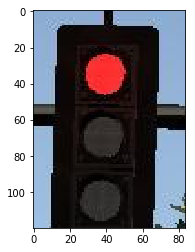

0r1.jpeg


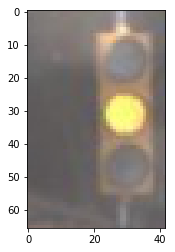

0r2.jpeg
0r3.jpeg


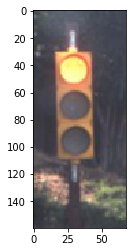

0s1.jpeg


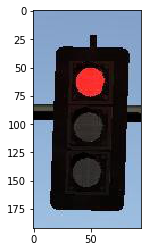

0s2.jpeg


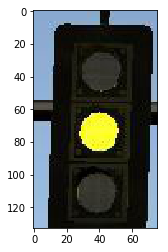

0s3.jpeg


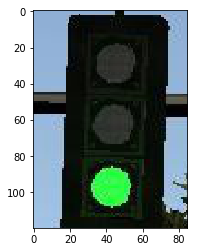

1.jpg


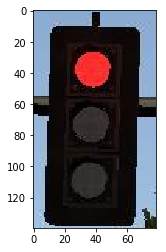

2.jpg


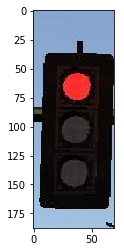

3.jpg


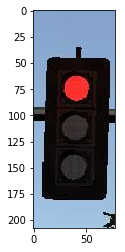

4.jpg


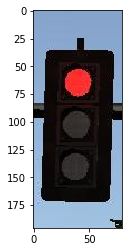

5.jpg


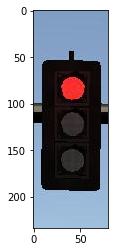

6.jpg


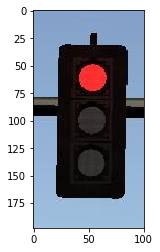

7.jpg


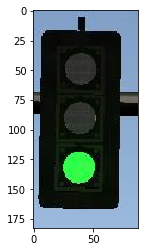

just_traffic_light_0002.jpg


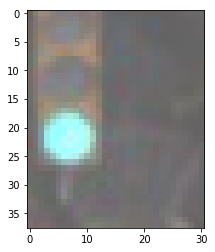

just_traffic_light_0051.jpg


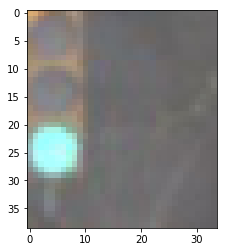

just_traffic_light_0127.jpg


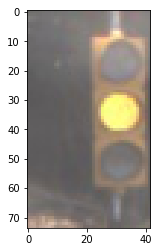

just_traffic_light_0201.jpg
just_traffic_light_0410.jpg


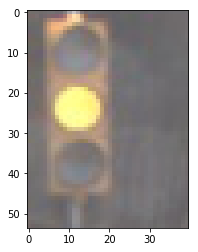

just_traffic_light_0469.jpg


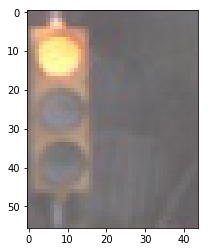

just_traffic_light_0601.jpg


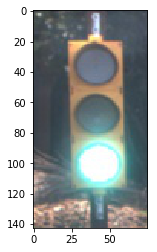

left0000.jpg


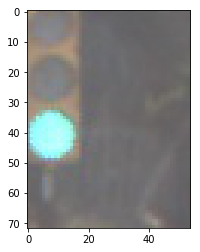

left0003.jpg


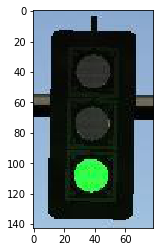

left0011.jpg


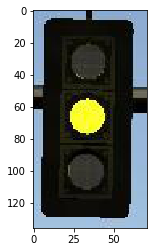

left0027.jpg


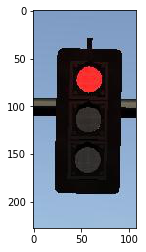

left0034.jpg


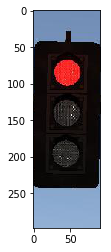

left0036.jpg


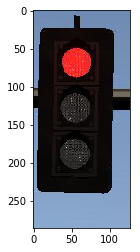

left0040.jpg


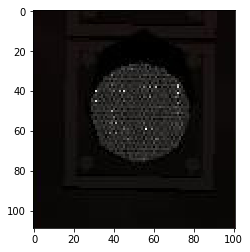

left0048.jpg
left0140.jpg


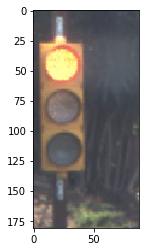

left0183.jpg


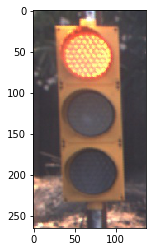

left0282.jpg


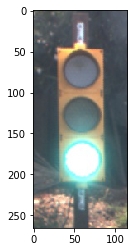

left0358.jpg


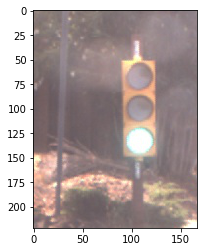

left0528.jpg


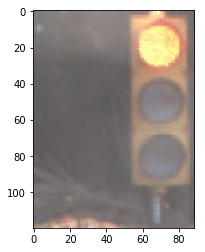

left0545.jpg


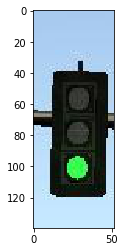

left0560.jpg


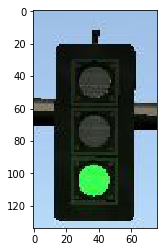

left0561.jpg


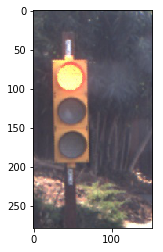

left0588.jpg


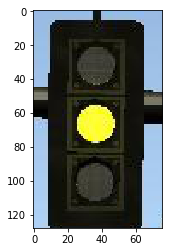

left0606.jpg


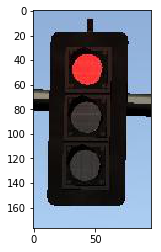

left0607.jpg


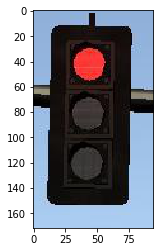

left0681.jpg


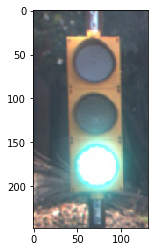

left0701.jpg


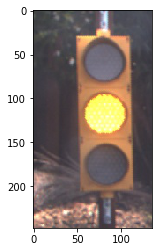

loop_with_traffic_light_0067.jpg
loop_with_traffic_light_0178.jpg
loop_with_traffic_light_0281.jpg


In [17]:
for image_path in images_path:
    print(image_path)
    image= mpimg.imread('test_images/'+image_path)
    img=image
    image=cv2.resize(image, (416, 416))
    image=(np.array(image,dtype=np.float)/255)
    image = np.expand_dims(image, 0)
    np.random.seed(0)
    a=model.predict(image)
    bboxes=get_YOLO_boxes(a,OBJ_THRESHOLD,NMS_THRESHOLD,ANCHORS)
    bboxes=NMS(bboxes,a,OBJ_THRESHOLD,NMS_THRESHOLD,ANCHORS)
    draw_image=draw_bboxes(img,bboxes,LABELS,WANTED_LABELS)
    if np.shape(draw_image)!=():
        plt.figure()
        plt.imshow(draw_image)
        plt.show()
        cv2.imwrite('test_images_output/'+image_path,cv2.cvtColor(draw_image,cv2.COLOR_RGB2BGR))